In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The standard library for data in tables
import pandas as pd

# A tiny function to read a file directly from a URL
from urllib.request import urlopen 

# Feeling Misérable

For our first case study, we will look at a French novel classic: Les Misérables by Victor Hugo.

Using an English translation of this book, we can demonstrate the workflow common in text analysis:
1. Reading in the data.
2. Cleaning the text.
3. Tokenize the text.
4. Extract features.
5. Do an analysis.

## Part 1: Reading in the Data

www.gutenberg.org has free copies of books that are in the public domain. Using their website, I found the link to the text file and can retrieve it using `requests`.

#### Reading the book

In [ ]:
import requests

r = requests.get('http://www.gutenberg.org/files/135/135-0.txt')
r.status_code

In [ ]:
print(r.text[:90])

Uh oh, what just happened here?

### __Unicode__
If you've ever typed in another language other than English and had it come out garbled, you have bumped up against encoding problems.

In the original character set, called ASCII, there was usually only space for English characters.

__Unicode__ came around and become a standard adopted across the web, especially UTF-8.

UTF-8 is now the encoding that represents all languages.

So what did our request read in?

In [ ]:
r.encoding

Which is a Latin encoding that misinterpreted the accented e in Misérable.

In [ ]:
r.encoding = "utf-8"

print(r.text[:90])

Much better!

## Part 2: Text Cleaning
There are a few issues I need to address with this text before continuing.
- Accent characters are hard to type on an American keyboard.
- There are still characters like `\n` and `\r` in the text.
- Capitalization and punctuation.

Most of this can be taken care of with built-in Python string methods.

### Decoding accented characters

Since the book is originally in French (and so the place names and names are in French), I'm going to strip all the letters of their accents to make it easier to use an English keyboard.

In [ ]:
book_text = r.text

from unidecode import unidecode as unidec

book_text = unidec(book_text)

book_text[:90]

Now it's back to ASCII

__When would this not be a good idea?__

### Main Text Extraction
Before we go any farther, I'm going to extract the actual main text.

#### Finding the main text

This book actually has a ton a preamble to it, including publisher information and a table of contents.

In [ ]:
print(book_text[:25000])

How do we strip away all of this unneccesary information? Two ways:

1. Just find at which character the book actually begins.
2. Find a key word to split on.

Both of these work, the second one is by far the best use of our time. After searching through the text for a while, you'll notice that the book begins with a part called "Preface." If we split on this word, we will have three parts because the word Preface appears in the TOC and also before the main text:

In [ ]:
[len(x) for x in book_text.split("PREFACE")]

Using that list comprehension we see three chunks, the last one is the biggest, and upon inspection:

In [ ]:
print(book_text.split("PREFACE")[2][:1155])

We would notice that this is the beginning Preface, whereas the first and second:

In [ ]:
print(book_text.split("PREFACE")[0][:50])

In [ ]:
print(book_text.split("PREFACE")[1][:50])

are not the parts we want. So let's just get the ``main text''

In [ ]:
main_text = book_text.split("PREFACE")[-1]

__Also: You might notice that theres a bunch of junk at the end of this text that is not the book__:

In [ ]:
print(main_text[-3000:])

This information about the book, not the text itself. After searching for a while, you would find the phrase:

"END OF THE PROJECT GUTENBERG EBOOK LES MISERABLES"

Which is a place you can do a split:

In [ ]:
[len(x) for x in main_text.split("END OF THE PROJECT GUTENBERG EBOOK LES MISERABLES")]

In [ ]:
main_text = main_text.split("END OF THE PROJECT GUTENBERG EBOOK LES MISERABLES ")[0]

In [ ]:
print(main_text[-1000:])

Those are the footnotes, so we now have all the text.

### Lesson here: the use of `.split()`

Finding the parts of a text document you need can involve a lot of trial and error. While I did need to inspect the text alot, you'll notice that using `.split()` makes it so I don't need to search too much.

### Removing `\n` and `\r`

This can be done using the replace function for strings. You will notice that they always appear in pairs:

In [ ]:
main_text = main_text.replace("\r\n"," ")

main_text[:75]

__When is this not a good idea?__

#### This is not a good idea if "paragraphs" were the unit of analysis I cared about.

In this example, I'm going to analyze chapters instead of paragraphs.

### Capitalization and punctuation
Why do we not want it?
   - Capitalization will make words be treated differently if they come at the beginning of a sentence.
   - Punctuation such as colons or apostraphes make new words: `"therefore:" != "therefore"`

In [ ]:
import string
string.punctuation

# This maketrans function can be used to remove a list of characters from a string.
remv_punc = str.maketrans('','',string.punctuation)

book_text.translate(remv_punc)[:200]

__When is this a bad idea?__

__It's a bad idea when punctuation is important__
- It takes out hyphens of words: "e-books" becomes "ebooks"
- Sentence structure will be completely gone.
- Quotations can no longer be found.

### An Aside: A Use for Regular Expressions
I pointed out that we could try and extract quotes from the book using the quotation marks. How would we do this?

A regular expression can do this. Regular expressions (regex for short) are a language that uses normal characters and also "meta characters" match patterns in strings.

A very short list of regex meta characters:
- `\s` whitespace
- `\d` digit
- `\w` word
- `.` any character but linebreak

Where capitals of these same characters is the complement of them (`\D` is "not a digit")


In [ ]:
import re
ex = "find 2 this digit: 82"
re.findall("\d",ex), re.findall(": \d",ex)

In the first one I asked for all digits, in the second one I just asked for the digit coming after a colon.

We also have "quantifiers":
- `+` one or more
- `{2}` exactly two instances
- `{2,9}` at least two, no more than nine instances.
- `*` zero or more times.
- `?` zero or one times.

In [ ]:
ex = "find 2 this digit: 897 23"
re.findall("\d",ex), re.findall("\d+",ex),re.findall("\d{3}",ex)

Greedy versus lazy quantifiers:

In [ ]:
ex

In [ ]:
re.findall("(\w.*) ",ex), re.findall("(\w.*?) ",ex)

Why did one return one long string and the other the individual words?

__Greedy__ quantifiers (no `?`) find the first instance and don't stop until it finds the last closing character.

__Lazy__ quantifiers (with `?`) find the first instance and stop at the first closing character and then starts again.

In this case the greedy version kept looking for a white space until it couldn't find one anymore.

The lazy version found whitespace after `find` and so stopped and started again.

Regex takes (in my experience) a stupid amount of time to master, but is VERY powerful.

### How do we find quotes?
Use this regex: `"(.*?)"`

In [ ]:
re.findall(r'"(.*?)"',main_text)

### More string methods
Finally, to make things lowercase there is a built-in string method:

In [ ]:
main_text.lower()[:200]

Some other methods:

In [ ]:
main_text.upper()[:200]

In [ ]:
main_text.title()[:200]

## Part 3: Tokenizing
### Example 1: Words

In [ ]:
clean_text = book_text.split("PREFACE")[-1].replace("\r\n"," ")
clean_text = clean_text.translate(remv_punc)
clean_text = clean_text.lower()

clean_text[:100]


Easiest way to "tokenize" is to split on the whitespace


In [ ]:
all_words = clean_text.split(" ")

Going to cheat and use Pandas to get a top count of all the words really fast. I'm going to put this list into a series and call the function "value_counts" on it:

In [ ]:
pd.Series(all_words).value_counts().head(100)

Problem here is that its picking up words we don't care about like "the" and "of" and also punctuation. This is why we use stopwords!

Now we will use a list of stopwords and remove them.

In [ ]:
from nltk.corpus import stopwords

# Using a series and index selection
WC = pd.Series(all_words).value_counts()

WC = WC[~WC.index.isin(stopwords.words("english"))]

Top ten words:

In [ ]:
WC.head(10)

So we picked up some white space, but we can add to the list of stopwords:

In [ ]:
stopwords_=stopwords.words("english")+["","m","said","will","one","two"]

WC = WC[~WC.index.isin(stopwords_)]

WC.head(10)

#### Bonus Assignment 1: N-Grams in Les Mis

What if we used n-grams to do the above analysis? Would what we see change?

#### Bonus Assignment 2: Stemming in Les Mis

How would our word counts change if first applied a stemming algorithm?

### Visualizations of Word Counts
I'm going to call from a package called "wordcloud," which does a lot of the work for us. All we need to do is feed it a string:

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

Call the function:

In [ ]:
wordcloud = WordCloud(stopwords=stopwords_ +['one','said',"two"])
wordcloud.generate(clean_text)

The object we create here actually can be displayed by calling the matplotlib function "imshow":

In [ ]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

__Bonus: Use a mask to put the words in a certain shape__

I'm reading in an image from the internet which is the title text used for the musical version.

In [ ]:
from PIL import Image
import numpy as np

# We're going to read in the image like an array
mask = np.array(Image.open("./Les-Miserables-Black.png"))[:-100,:,:]

mask

The word cloud function requires that the image "background" be 255.

Here's what it looks like.

In [ ]:
plt.imshow(mask[:,:,:])

Now here's the wordcloud object, but using the "mask" argument.

In [ ]:
wordcloud = WordCloud(stopwords=stopwords_,\
                      mask=mask,
                      colormap="RdBu",
                      max_words=1000,
                      width=1200, 
                      height=800,
                      background_color="black",
                      font_path='arial').generate(clean_text)

In [ ]:
plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig("Les_Mis_wc.png",dpi=350,bbox_inches="tight")

### Example 2: Chapters

How many times does a character appear in each chapter?

To do this kind of analyis, we will use chapters as units of analysis. In the "Coding for Data Science" course they did a count of number of times a character gets mentioned in a chapter of Pride and Prejudice:
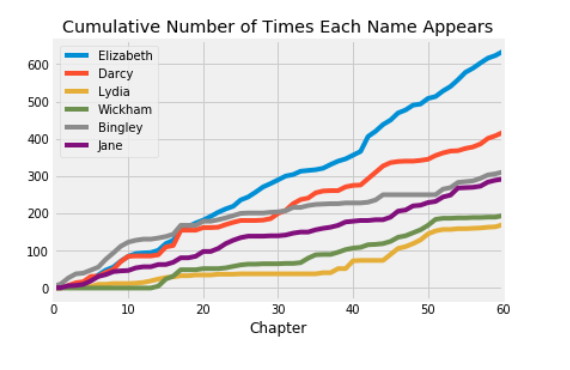

For Les Mis, its an even greater undertaking given the number of characters.

This book has several characters that cycle throughout the story, so one analysis we could do is: how does the focus of the story shift from one character to another throughout the book?

### Step 1: Split the book into chapters.

Note that there are 365 chapters in the book. The easiest thing to start with the main text that we used before.

In [ ]:
chapters = main_text.split("CHAPTER")

To check whether we did it alright, let's look at the number of chapters

In [ ]:
len(chapters)

Uh oh, what went wrong? Let's look at the length of the chapters.

In [ ]:
chapter_lengths = pd.Series([len(x) for x  in chapters])
chapter_lengths.sort_values()

Hmmmm, so the 33rd chapter has only 7 characters, meaning its likely an error. We've also included the Preface, but we will keep that in.

Let's plug those index numbers in to see what they look like.

In [ ]:
chapters[33], chapters[34][:100],chapters[0]

So we can confirm that we have an error at position 33 and we have the preface 0. We can use the "pop" function, which will remove an element from a list.

In [ ]:
chapters.pop(33)

In [ ]:
chapter_lengths = pd.Series([len(x) for x  in chapters])
chapter_lengths.sort_values()

Now it is gone!

### Side Note: A Good Application for TF-IDF
When we did our word counts, we sometimes got far too many common words and not enough meaningful words.

... but what is a "meaningful word"?

One definition search algorithms often use is __Term Frequency - Inverse Document Frequency (TF-IDF)__. Here we introduce the idea of a "document" which is the unit of analysis we are using (in this case chapters).

__Term frequency__: how often does a  word appear in a document?

__Document frequency__: How many documents contain this word?

Then $TF-IDF = TF/DF$, so we divide term frequency by the total number of documents that have that word.

__What is the advantage of doing this instead of just using term frequency?__

Essentially, this gives a high score to words that feature in a document but are __specific to a document__.

For example, the word "man" may be a very frequent word but it could be used as a broad term for humanity and would appear in every chapter.

In contrast, the word "barricade" is likely to feature heavily in the last part of the book but not in the whole text. Indeed, the word "barricade" is a large part of the story at that point, so it is somewhat meaningful.

Why is this useful?

Let's do it. First, I wrote a function to clean our chapters.

In [ ]:
def tokenize(string):
    string = string.replace("\r\n"," ")
    string = string.lower()
    string = string.replace("-"," ")
    string = string.translate(remv_punc)
    words = string.split(" ")
    words = [x for x in words if x!=""]
    words = [x for x in words if x not in stopwords_]
    return words

chapters_tokenized = [tokenize(x) for x in chapters]

Next let's create a word matrix like we have done before:

In [ ]:
word_matrix = pd.concat([pd.Series(x).value_counts() for x in chapters_tokenized],axis=1).fillna(0)
word_matrix.head()

Method \#1: Groupby

One way to get tf is just with a groupby method:

In [ ]:
def tf_calc(column):
    return column/column.sum()

tf = word_matrix.apply(tf_calc,axis=1)
tf

Notice how slow it is...

Now calculate IDF:

In [ ]:
inv_doc_freq = np.log(tf.shape[1]/(word_matrix!=0).sum(axis=1))
inv_doc_freq

Method \#2: VECTORIZE

In [ ]:
idf_mat= np.repeat(np.array(inv_doc_freq)[:,np.newaxis],\
                   tf.shape[1],\
                   axis=1)

tf_idf = tf*idf_mat

What did I just do there, and why was it so much faster?

Now let's look at different chapters and their top words:

In [ ]:
chapter_no = 200
tf_idf[chapter_no].sort_values(ascending=False).head(30)

### Step 2: Take Character Counts
Using the other python tutorial, we can steal their count_character function.

In [ ]:
def count_character(chapter,name):
    return np.char.count(chapter,name)

Now let's make a list of some main characters.

In [ ]:
characters = ["Fantine","Marius","Cosette","Jean Valjean","Javert","Bishop"]

And now we can evaluate the function. Notice that the numpy function accepts a list:

In [ ]:
count_character(chapters,characters)

There are many ways to do this, but the easiest way to plot is actually to create a DataFrame.

In [ ]:
# This creates a list of Pandas Series objexts.
character_counts = [pd.Series(count_character(chapters,character)) for character in characters]

# pd.concat accepts a list of series objects and can make a Dataframe.
character_df = pd.concat(character_counts,axis=1)

# Rename the colums now.
character_df.columns = characters

character_df

### Step 3: Plot the Data

Now we can just call plot:

In [ ]:
f,a = plt.subplots(figsize = (20, 5))

character_df.plot(ax=a)
plt.xticks(np.arange(1,365,20));
plt.xlim(0,370)
plt.xlabel("Chapter Number")

Oof, this isn't very pretty. So two options:

1. Do "cumulative sum" like in the tutorial

2. Take a rolling average to smooth it out

__Cumulative Sum__:

In [ ]:
f,a = plt.subplots(figsize = (20, 5))

character_df.cumsum().rolling(3).mean().plot(ax=a)
plt.xticks(np.arange(1,365,20));
plt.xlim(0,370)
plt.xlabel("Chapter Number")
plt.ylabel("Total Mentions)")

__Rolling Mean, 10 chapters:__

In [ ]:
f,a = plt.subplots(figsize = (20, 5))

character_df.rolling(10).mean().plot(ax=a)
plt.xticks(np.arange(1,365,20));
plt.xlim(0,370)
plt.ylim(0,20)
plt.ylabel("Average Mentions (10 Chapter Average)")
plt.xlabel("Chapter Number")

### Example 3: Sentiment Analysis
Now that we have it broken on chapters, we can do a sentiment analysis.

Sentiment analysis is an example of a NLP routine to analyze whether a text is positive or negative. We can use the nltk package, feed in a chapter, and then get the "compound score."

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

First creat a sentiment analysis instance:

In [ ]:
sid = SentimentIntensityAnalyzer()

Now using a list comprehension, we can run each chapter through the algorithm

In [ ]:
pol_scores = [sid.polarity_scores(x)['compound'] for x in chapters]

pol_scores

Basic histogram:

In [ ]:
pd.Series(pol_scores).plot(kind='hist',bins=20)

One thing you should notice at this point is that the alogorithm predicts really close to zero and one. This is likely because the algorithm is for social media, and we just fed it a 19th century French novel. 

It would make sense then that this rule based method doesn't find a lot of nuance.

### Plotting Sentiment over the Book

In [ ]:
f,a = plt.subplots(figsize = (10, 5))
pd.Series(pol_scores).plot(ax=a)
plt.xticks(np.arange(1,365,20));
plt.xlim(0,370)

plt.axhline(0,color='black',)

Gross.

But from this we can see that there are periods of sustained positivity and then more negative parts.

Using our rolling average, we can make it look a little clearer:

In [ ]:
f,a = plt.subplots(figsize = (10, 5))
pd.Series(pol_scores).plot(ax=a,alpha=.2)
pd.Series(pol_scores).rolling(20).mean().plot(ax=a,color="black")
a.axhline(0,color='black',ls='--')
plt.ylabel("Sentiment Score")
plt.xticks(np.arange(1,365,20));
plt.xlim(0,370)

We can try to graph all of them together to give it this look:

In [ ]:
f,a = plt.subplots(figsize = (20, 5))
pd.Series(pol_scores).plot(ax=a,alpha=.05,color='grey',label="Raw Sentiment Score")
pd.Series(pol_scores).rolling(20).mean().plot(ax=a,color="black",alpha=1,label="Average Sentiment Score")
a.axhline(0,color='black',ls='--')
a.set_ylabel("Sentiment Score")
a.legend(loc=(0,-.25))
plt.xticks(np.arange(1,365,20));
plt.xlim(0,370)

ax2 = a.twinx()

ax2.set_ylabel("Average Character Count")
character_df.rolling(10).mean().plot(ax=ax2,alpha=.5)
ax2.legend(loc=(.935,-.4))

How does it match up with the Hedonometer readings?
<center>

<img src="hedonometer_reading.png">
</center>


Note: a look at the plot of the book can give you details about some things that happen. For example:
1. Fantine appears around Chapter 30 as noted in the character plots, but begins a slow slide into poverty, leading her to give charge of her daughter Cosette to the Thenardiers, a cruel family that mistreats her. Fantine loses her job at the mill and becomes a prostitute. She later dies after giving Valjean the task of taking care of her daughter. This is somewhat shown by a gradual decline in sentiment after her appearence.
2. Victor Hugo at about chapter 70 starts ranting about the battle of Waterloo. This causes a big swing towards negative sentiment (the French lost that battle).


3. Some decades later, Marius appears at chapter 160, and he is an idealistic young revolutionary. He also falls in love with the now older Cosette, which appears to cause a spike in sentiment.
4. The final conflict of the book is the revolution, which ultimately fails and leads to the deaths of some other major characters such as Gavroche, Enjolras, and Eponine. This decline in sentiment from the highs of Marius and Cosette being in love are reflected in the scores. Javert also dies, thus why his character trend dissapears.
5. Marius and Cosette get married, while Valjean runs away to live at a convent (ironically) and wrestle with the guilt of his past life as a criminal. The book ends with him dying, but with Cosette and Marius at his side. This somewhat hopeful ending contributes to the spike in sentiment at the end.

### Example 4: Character Correlations

Let's add this to our "character" dataframe and then call "correlation" on the dataframe.

In [ ]:
character_df['sentiment'] = pd.Series(pol_scores)
character_df['sentiment_rm20'] = pd.Series(pol_scores).rolling(20).mean()
character_df['sentiment_rm10'] = pd.Series(pol_scores).rolling(10).mean()

character_df.corr().iloc[:-3,-3:]

Javert, being the main villain of the book, has the lowest sentiment while Cosette and Marius, the heros of the book, have the highest sentiment score (as well as Cosette's mother Fantine, who dies early on in the book). Interestingly, Valjean has an almost neutral sentiment, possibly because he is the character who is "reforming himself" throughout the book.

### LDA Analysis

In [ ]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import common_texts
from gensim.models.ldamodel import LdaModel
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from gensim import models

In [ ]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

def tokenize(string):
    string = string.replace("\r\n"," ")
    string = string.lower()
    string = string.replace("-"," ")
    string = string.translate(remv_punc)
    words = string.split(" ")
    words = [x for x in words if x!=""]
    words = [x for x in words if x not in stopwords_+['man']]
    words = [get_lemma(x) for x in words]
    return words

Regular LDA model

In [ ]:
chapters_tokens = [tokenize(x) for x in chapters]
chapter_dict =  Dictionary(chapters_tokens)
chapter_corpus = [chapter_dict.doc2bow(text) for text in chapters_tokens]
lda = LdaModel(chapter_corpus, num_topics=3,id2word=chapter_dict)

lda.print_topics(num_words=10)

LDA model using TF-IDF scoring

In [ ]:
tfidf = models.TfidfModel(chapter_corpus)
corpus_tfidf = tfidf[chapter_corpus]
lda = LdaModel(corpus_tfidf, num_topics=5,id2word=chapter_dict)
lda.print_topics(num_words=10)